# Tworzenie sieci neuronowej

W tym zadaniu stworzymy w pełni połączoną sieć neuronową przy użyciu niskopoziomowych mechanizmów tensorflow.

Architektura sieci neuronowej została przedstawiona na poniższym rysunku. Jak widać, ma ona jedną warstwę wejściową, dwie warstwy ukryte i warstwę wyjściową. W warstwach ukrytych wykorzystamy sigmoid jako funkcję aktywacji. Na warstwie wyjściowej użyjemy softmax.

Część kodu do utworzenia sieci została już napisana, musisz wypełnić puste miejsca w określonych miejscach.

## Architektura sieci neuronowej

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Informacje o zestawie danych MNIST

Będziemy trenować tę sieć neuronową na zbiorze danych MNIST. Ten zbiór danych to duża liczba odręcznych obrazów cyfr składających się z 28 razy 28 pikseli. Każdy piksel przyjmuje wartość od 0 do 255.

Tak jak poprzednio, zbiór danych zostanie podzielony na próbki treningowe i testowe. Znormalizujemy wszystkie obrazy tak, aby wartości pikseli wynosiły od 0 do 1, dzieląc jasność każdego piksela przez 255.

Ponadto architektura sieci neuronowej oczekuje wektora jako danych wejściowych. W naszym przypadku jednak każdy przykładowy obiekt jest macierzą. Co należy zrobić? W tym zadaniu "rozciągniemy" macierz 28 razy 28$, uzyskując w ten sposób wektor składający się z 784 elementów.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Więcej informacji na temat zbioru danych można znaleźć na stronie [tutaj](http://yann.lecun.com/exdb/mnist/).

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

In [13]:
num_classes = 10 # całkowita liczba klas, w naszym przypadku są to liczby od 0 do 9
num_features = 784 # liczba atrybutów wektora wejściowego 28 * 28 = 784

learning_rate = 0.001 # szybkość uczenia się sieci neuronowej
training_steps = 3000 # maksymalna liczba epok
batch_size = 256 # przeliczymy wagi sieci nie na całej próbce, ale na jej losowym podzbiorze elementów bat
display_step = 100 # co 100 iteracji pokażemy aktualną wartość funkcji straty i dokładności

n_hidden_1 = 128 # liczba neuronów warstwy 1
n_hidden_2 = 256 # liczba neuronów warstwy 2

In [14]:
import tensorflow as tf
import keras
# Ładowanie zestawu danych
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Konwersja pikseli całkowitych na typ float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Konwertujemy macierze 28x28 pikseli na wektor składający się z 784 elementów
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalizacja wartości pikseli
x_train, x_test = x_train / 255., x_test / 255.

# Zmiksujmy dane treningowe
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [15]:
# Stwórzmy sieć neuronową

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
        tf.random.normal([in_features, out_features]), name="w"
      )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.relu(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    in_out = [num_features, n_hidden_1, n_hidden_2, num_classes]
    layers = []

    # Tworzenie warstw
    for i in range(len(in_out)-1):
      layers.append(DenseLayer(in_out[i], in_out[i+1], "layer"))

    self.layers = layers

  def __call__(self, x):
     i = 0
     n = len(self.layers) # 3

     for layer in self.layers:
      i += 1
      x = layer(x)

      if i < n:
        x = tf.nn.sigmoid(x) # 1, 2
      else:
        x = tf.nn.softmax(x) # 3


     return x

In [16]:
import tensorflow as tf
import keras
import numpy
# W tym przypadku wygodnie jest przyjąć entropię krzyżową jako funkcję błędu
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Obliczanie entropii krzyżowej
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Jako miernik jakości stosujemy dokładność
def accuracy(y_pred, y_true):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)
    correct_prediction = tf.equal(y_pred, y_true)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()

In [17]:
# Stwórzmy przykładową sieć neuronową
neural_net = NN(name="mnist")

# Funkcja treningu sieci neuronowej
def train(nn, input_x, output_y):
  # Do dopasowania wag sieci wykorzystamy stochastyczne zejście gradientowe
  optimizer = tf.optimizers.SGD(learning_rate)

  # Aktywacja automatycznego różnicowania
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
    # Utwórz zoptymalizowaną listę parametrów
    variables = [layer.w for layer in nn.layers] + [layer.b for layer in nn.layers]
    # Oblicz na ich podstawie wartość gradientu
    gradient = g.gradient(loss, variables)
    # Zmodyfikuj parametry
    optimizer.apply_gradients(zip(gradient, variables))
    return loss

In [18]:
# Szkolenie sieciowe

loss_history = []  # każdy krok display_step zapisuje bieżący błąd sieci neuronowej na tej liście
accuracy_history = [] # każdy krok display_step zapisuje aktualną dokładność sieci neuronowej na tej liście
displays_steps = []

# W tej pętli będziemy trenować sieć neuronową
# Z treningowego zbioru danych train_data, wyodrębnij losowy podzbiór, na którym
# będzie trenowana. Użyj metody take dostępnej dla szkoleniowego zbioru danych.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Aktualizacja wag sieci neuronowej

    loss  = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss_history.append(cross_entropy(pred, batch_y).numpy())
        accuracy_history.append(accuracy(pred, batch_y))
        displays_steps.append(step)
        print(f"Step: {step}")
        print(f"Loss: {loss:.4f}")
        print(f"Accuracy: {accuracy_history[-1]:.4f}")


Step: 100
Loss: 589.6511
Accuracy: 0.1211
Step: 200
Loss: 589.4695
Accuracy: 0.0664
Step: 300
Loss: 589.4879
Accuracy: 0.1094
Step: 400
Loss: 589.5140
Accuracy: 0.0625
Step: 500
Loss: 589.4311
Accuracy: 0.0859
Step: 600
Loss: 589.4619
Accuracy: 0.1133
Step: 700
Loss: 589.1633
Accuracy: 0.1367
Step: 800
Loss: 588.6454
Accuracy: 0.0820
Step: 900
Loss: 592.8539
Accuracy: 0.1055
Step: 1000
Loss: 585.3575
Accuracy: 0.1484
Step: 1100
Loss: 560.5860
Accuracy: 0.1602
Step: 1200
Loss: 578.7496
Accuracy: 0.1523
Step: 1300
Loss: 561.9536
Accuracy: 0.1562
Step: 1400
Loss: 554.8679
Accuracy: 0.1875
Step: 1500
Loss: 551.4933
Accuracy: 0.1836
Step: 1600
Loss: 546.7151
Accuracy: 0.1836
Step: 1700
Loss: 548.8685
Accuracy: 0.1602
Step: 1800
Loss: 553.5790
Accuracy: 0.1914
Step: 1900
Loss: 529.9714
Accuracy: 0.2188
Step: 2000
Loss: 542.7983
Accuracy: 0.1797
Step: 2100
Loss: 531.3085
Accuracy: 0.2031
Step: 2200
Loss: 544.3505
Accuracy: 0.2031
Step: 2300
Loss: 559.5860
Accuracy: 0.1719
Step: 2400
Loss: 538

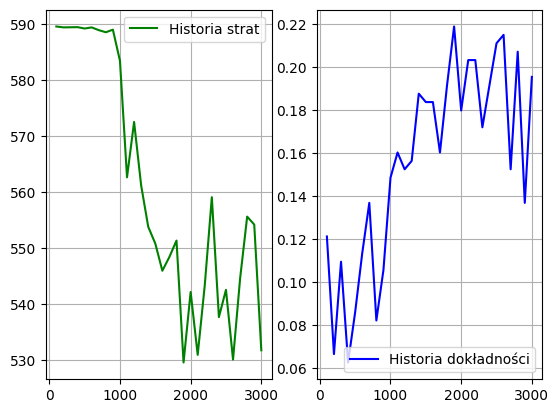

In [19]:
# Wykreśl zmianę dokładności i strat jako funkcję skoku
# Jeśli zostanie to zrobione poprawnie, dokładność powinna wzrosnąć, a straty powinny się zmniejszyć.

plt.subplot(1, 2, 1)
plt.plot(displays_steps, loss_history, color='g')
plt.grid(True)
plt.legend(["Historia strat"])
plt.subplot(1, 2, 2)
plt.plot(displays_steps, accuracy_history, color='b')
plt.grid(True)
plt.legend(["Historia dokładności"])

In [20]:
# Oblicz dokładność wytrenowanej sieci neuronowej

acc = accuracy(neural_net(x_test), y_test)
print(acc)

0.1857


7


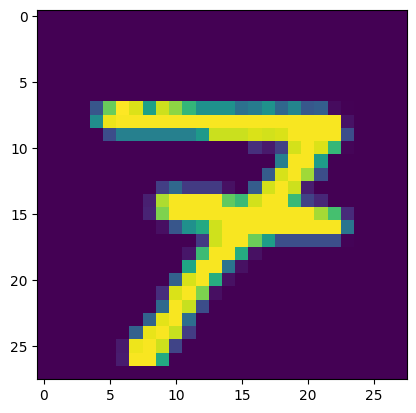

In [21]:
# Przetestuj wytrenowaną sieć neuronową na 10 obrazach. Z próbki testowej wybierz 5
# losowych obrazów i wprowadź je do sieci neuronowej.
# Wyprowadź obraz i zapisz obok niego odpowiedź sieci neuronowej.
# Czy sieć neuronowa się myli, a jeśli tak, to jak często?

sample_num = 64
x1 = x_test[sample_num].reshape(28, 28)
print(y_test[sample_num])
plt.imshow(x1)

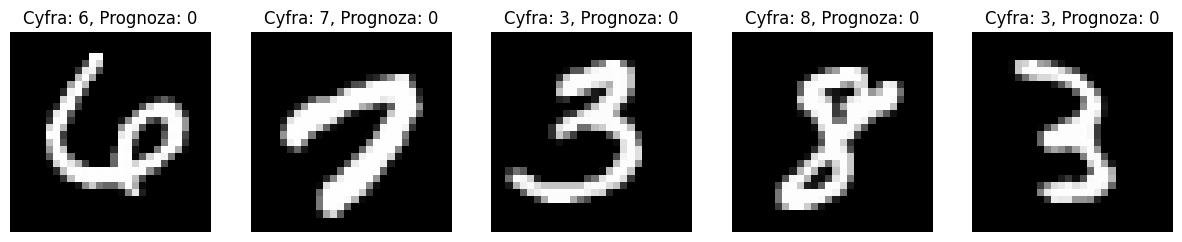

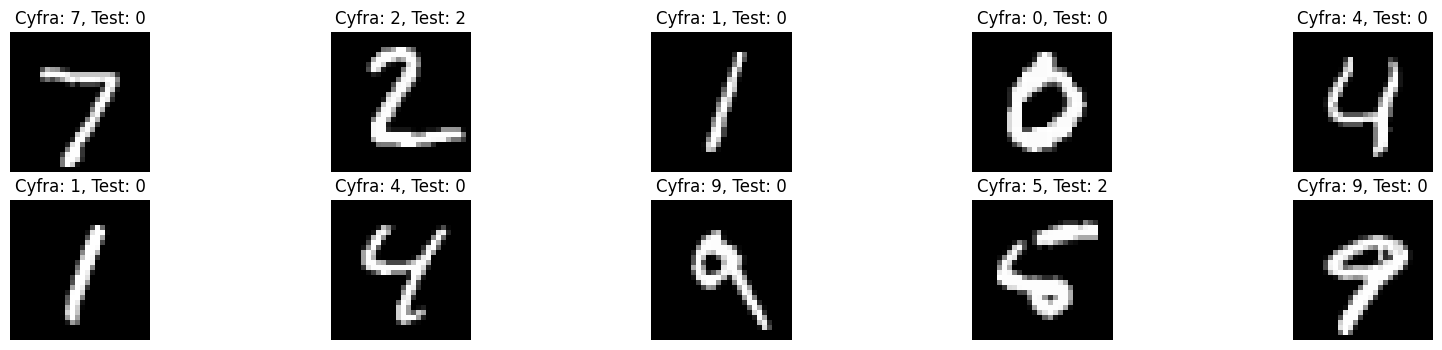

Poprawne: 2
Niepoprawne: 8
Dokładność na 10 obrazach: 0.2000


In [22]:
import random

num_samples = 5
random_indices = random.sample(range(x_test.shape[0]), num_samples)
random_images = x_test[random_indices]
random_labels = y_test[random_indices]

predictions = neural_net(random_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

plt.figure(figsize=(15, 3))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(random_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Cyfra: {random_labels[i]}, Prognoza: {predicted_labels[i]}")
    plt.axis('off')
plt.show()

num_test_samples = 10
test_predictions = neural_net(x_test[:num_test_samples])
test_predicted_labels = tf.argmax(test_predictions, axis=1).numpy()


plt.figure(figsize=(20, 4))
for i in range(num_test_samples):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Cyfra: {y_test[i]}, Test: {test_predicted_labels[i]}")
    plt.axis('off')
plt.show()

correct_predictions = sum(y_test[:num_test_samples] == test_predicted_labels)
incorrect_predictions = num_test_samples - correct_predictions

print(f"Poprawne: {correct_predictions}")
print(f"Niepoprawne: {incorrect_predictions}")
print(f"Dokładność na 10 obrazach: {correct_predictions / num_test_samples:.4f}")


In [28]:
import random

num_samples = 50
random_indices = random.sample(range(x_test.shape[0]), num_samples)
random_images = x_test[random_indices]
random_labels = y_test[random_indices]

predictions = neural_net(random_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

num_test_samples = 1000
test_predictions = neural_net(x_test[:num_test_samples])
test_predicted_labels = tf.argmax(test_predictions, axis=1).numpy()

correct_predictions = sum(y_test[:num_test_samples] == test_predicted_labels)
incorrect_predictions = num_test_samples - correct_predictions

print(f"Poprawne: {correct_predictions}")
print(f"Niepoprawne: {incorrect_predictions}")
print(f"Dokładność na 1000 obrazach: {correct_predictions / num_test_samples:.4f}")


Poprawne: 182
Niepoprawne: 818
Dokładność na 1000 obrazach: 0.1820


Wnioski: Dokładność tego modelu jest na poziomie ok. 20%, co jest bardzo niskie dla klasyfikacji cyfr MNIST. Możliwe, że dobrane są niewłaściwe hiperparametry jak np. learning rate, batch size itp. Możliwe, że liczba kroków prowadzi do niedostatecznego trenowania modelu. Można spróbować użyć innej funkcji w warstwach ukrytych, np. ReLU. Używanie sigmoidu może prowadzić do problemów z zanikiem grafientu.